# How to use subgraphs
> https://langchain-ai.github.io/langgraph/how-tos/subgraph/

## Add a node with the compiled subgraph

In [20]:
from langgraph.graph import START, StateGraph
from typing import TypedDict
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Define subgraph
class SubgraphState(TypedDict):
    foo: str  # note that this key is shared with the parent graph state
    bar: str


def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}


def subgraph_node_2(state: SubgraphState):
    # note that this node is using a state key ('bar') that is only available in the subgraph
    # and is sending update on the shared state key ('foo')
    return {"foo": state["foo"] + state["bar"]}


subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


# Define parent graph
class ParentState(TypedDict):
    foo: str


def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
# note that we're adding the compiled subgraph as a node to the parent graph
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile(checkpointer=memory)

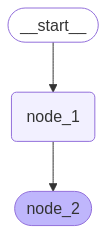

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
Image(subgraph.get_graph().draw_mermaid_png())

In [ ]:
for chunk in graph.stream({"foo": "foo"}):
    print(chunk)

In [ ]:
for chunk in graph.stream({"foo": "foo"}, subgraphs=True):
    print(chunk)

## Add a node function that invokes the subgraph

In [ ]:
# Define subgraph
class SubgraphState(TypedDict):
    # note that none of these keys are shared with the parent graph state
    bar: str
    baz: str


def subgraph_node_1(state: SubgraphState):
    return {"baz": "baz"}


def subgraph_node_2(state: SubgraphState):
    return {"bar": state["bar"] + state["baz"]}


subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


# Define parent graph
class ParentState(TypedDict):
    foo: str


def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}


def node_2(state: ParentState):
    # transform the state to the subgraph state
    response = subgraph.invoke({"bar": state["foo"]})
    # transform response back to the parent state
    return {"foo": response["bar"]}


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
# note that instead of using the compiled subgraph we are using `node_2` function that is calling the subgraph
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

In [ ]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [ ]:
for chunk in graph.stream({"foo": "foo"}, subgraphs=True):
    print(chunk)